# Long Short Term Memory (LSTM)

## Data import

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("Corona_NLP.csv", encoding='latin-1')
pd.options.display.max_colwidth = 500
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,"Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16. We will continue to process online and phone orders as normal! Thank you for your understanding! https://t.co/kw91zJ5O5i",Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona",Negative


In [3]:
df  = df[['OriginalTweet', 'Sentiment']].head(3000)

In [4]:
set(df['Sentiment'].values)

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'}

In [5]:
df['LabelSentiment'] = df['Sentiment'].apply(lambda x: 2 if x in ['Extremely Positive', 'Positive'] else (1 if x == "Neutral" else 0))

In [6]:
df.head()

,OriginalTweet,Sentiment,LabelSentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,1
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,2
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,2
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,2
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative,0


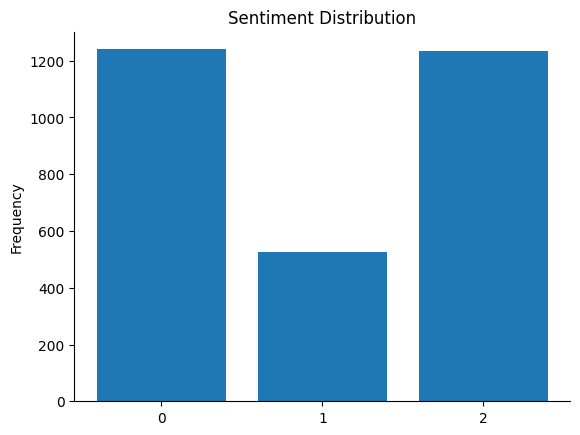

In [7]:
plt.bar(df['LabelSentiment'].value_counts().index,df['LabelSentiment'].value_counts().values)
plt.xticks([0,1,2])
plt.grid(False)
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Train - Test split

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(df['OriginalTweet'], df['LabelSentiment'], test_size=0.20, random_state=4)

In [9]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(2400, 600, 2400, 600)

## Clean Text

In [10]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [11]:
X_train_ = X_train.copy()

In [12]:
def clean(text_list):
    
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #SUBSTITUTE URL
        text = re.sub(r'http\S+', 'URL', text)
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #Lemmatize
        text = " ".join(lemma.lemmatize(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [13]:
x_train = clean(X_train)

  0%|          | 0/2400 [00:00<?, ?it/s]

In [14]:
x_test = clean(X_test)

  0%|          | 0/600 [00:00<?, ?it/s]

In [15]:
y_train = Y_train.to_numpy()

In [16]:
y_test = Y_test.to_numpy()

In [17]:
x_train[0:10]

['past week absolute nightmare may ask work grocery store let tell people asshole go grocery store nice people working putting life risk coronavirus',
 'california government need control go grocery store day control run supply well control many people one place given time store see packed parking lot coronavirus californiacoronavirus',
 'breaking gas price dropping tonight cent putting price litre metro van lowest year reason drop demand people staying home energy sector suffer',
 'old school alp wesstreeting hi wes come phone call t said much shop exploiting price handsanitizer unless government set cap chance call borisjohnson cap sto',
 'ummmmmmmmmm bout shit need jeanyuses cnn providing rock solid information always ay dios mio fakenews coronavirus URL',
 'god damn people jacking stuff grocery store people need ya know coronavirusoutbreak covid',
 'u retail sale february yoy indicating consumer spending major driver u economy trending prior covid thinkwhyitmatters',
 'pa state pol

## Feature Engineering (Word Embeddings)

In [18]:
import gensim.downloader

In [19]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [20]:
#glove-twitter-25 has embeddings size 25, glove-twitter-100 has embeddings size 100, etc.
w2v = gensim.downloader.load('glove-twitter-100')

In [21]:
emb_size = 100

In [22]:
#function to get embeddings for each word based on w2v list
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in w2v.index_to_key:
                doc_vectors.append(w2v.get_vector(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec

In [23]:
x_train_vec = corpus2vec(x_train)

  0%|          | 0/2400 [00:00<?, ?it/s]

In [24]:
x_test_vec = corpus2vec(x_test)

  0%|          | 0/600 [00:00<?, ?it/s]

## Pad Sequences

In [25]:
#!pip install tensorflow
#!pip install Keras-Preprocessing

In [26]:
import tensorflow as tf
import tensorflow.keras as keras

In [27]:
from keras_preprocessing.sequence import pad_sequences

In [28]:
#get list with lenghts of sentences
train_len = []
for i in x_train_vec:
    train_len.append(len(i))

In [29]:
max(train_len)

36

In [30]:
#make all sentences the same size - model input must be of the same size
X_pad = pad_sequences(maxlen=max(train_len),sequences=x_train_vec, padding="post", dtype='float64')

In [31]:
#we added dummy embedding at the end of each sentence so that they all have len 36
#let's look at the first sentence, word 18 to 36(end)
X_pad[0][18:]

array([[ 0.12863   , -0.25442001, -0.14914   , ...,  0.34277001,
        -0.22908001, -0.88897002],
       [ 0.031579  , -0.25907001,  0.62281001, ...,  0.026399  ,
         0.19357   ,  0.1015    ],
       [-0.19952001, -1.02680004,  0.14788   , ...,  0.1087    ,
         0.11457   , -0.65868998],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [32]:
#turn input into a tensor (another sort of array) for the model
X = tf.convert_to_tensor(X_pad, dtype='float32')

In [33]:
X.shape

TensorShape([2400, 36, 100])

In [34]:
y_train[0:10]

array([0, 2, 0, 0, 0, 0, 1, 2, 2, 0], dtype=int64)

In [35]:
#Must turn output into one hot encoded matrix
y = tf.one_hot(y_train, depth=3)

In [36]:
y[0:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

## Model Initiation and Train (LSTM)

Understanding LSTM Networks: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Illustrated Guide to LSTM’s and GRU’s: A step by step explanation: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

![LSTM](https://www.researchgate.net/publication/335524542/figure/fig11/AS:798002683842580@1567270074253/Mozilla-DeepSpeech-forward-LSTM-chain-this-should-the-only-used-part-after-mozillas.ppm)

In [37]:
#make the model start with same weights
tf.random.set_seed(221)
#import packages
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Bidirectional, Masking
from keras import layers

In [38]:
'''model input in the shape(number of words per doc, word embedding size)'''
input_ = Input(shape=(max(train_len), emb_size))
 
'''mask layer to avoid model from considering padding vectors'''
mask_layer = Masking(mask_value=0)
mask = mask_layer(input_)

'''BiLSTM layer'''
lstm = Bidirectional(LSTM(units=4))(mask)

'''activation layer'''
act = Dense(3, activation='softmax')(lstm)

'''model input and output'''
model = Model(input_, act)

'''model loss function and evaluation metrics'''
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36, 100)]         0         
                                                                 
 masking (Masking)           (None, 36, 100)           0         
                                                                 
 bidirectional (Bidirection  (None, 8)                 3360      
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)                 27        
                                                                 
Total params: 3387 (13.23 KB)
Trainable params: 3387 (13.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
history = model.fit(X, y, batch_size=32, epochs=10, verbose=1, validation_split=0.20)

Epoch 1/10
60/60 [==============================] - 7s 36ms/step - loss: 1.0729 - accuracy: 0.3953 - val_loss: 1.0132 - val_accuracy: 0.4750
Epoch 2/10
60/60 [==============================] - 1s 9ms/step - loss: 0.9823 - accuracy: 0.5036 - val_loss: 0.9667 - val_accuracy: 0.5292
Epoch 3/10
60/60 [==============================] - 1s 8ms/step - loss: 0.9275 - accuracy: 0.5646 - val_loss: 0.9024 - val_accuracy: 0.6021
Epoch 4/10
60/60 [==============================] - 1s 9ms/step - loss: 0.8705 - accuracy: 0.6042 - val_loss: 0.8571 - val_accuracy: 0.6417
Epoch 5/10
60/60 [==============================] - 1s 8ms/step - loss: 0.8281 - accuracy: 0.6302 - val_loss: 0.8267 - val_accuracy: 0.6646
Epoch 6/10
60/60 [==============================] - 1s 8ms/step - loss: 0.7915 - accuracy: 0.6531 - val_loss: 0.8071 - val_accuracy: 0.6708
Epoch 7/10
60/60 [==============================] - 1s 9ms/step - loss: 0.7585 - accuracy: 0.6729 - val_loss: 0.7928 - val_accuracy: 0.6833
Epoch 8/10
60/60 [=

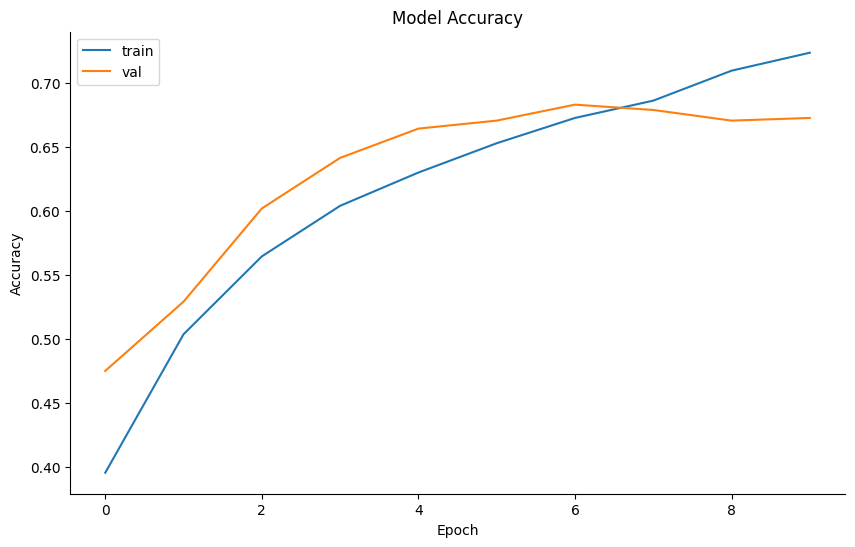

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize =(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Predict

In [41]:
X_test_pad = pad_sequences(maxlen=max(train_len),sequences=x_test_vec, padding="post", dtype='float64')

In [42]:
#x_test = np.expand_dims(x_test,-1)
x_test = tf.convert_to_tensor(X_test_pad, dtype='float32')

In [43]:
x_test.shape

TensorShape([600, 36, 100])

In [44]:
pred_y = model.predict(x_test)

19/19 [==============================] - 2s 4ms/step


In [45]:
pred_y[0:10]

array([[0.15977186, 0.0628108 , 0.7774173 ],
       [0.09595531, 0.77423704, 0.12980765],
       [0.8826377 , 0.02171526, 0.09564704],
       [0.28172824, 0.22572988, 0.49254182],
       [0.8860994 , 0.04423737, 0.06966327],
       [0.2905053 , 0.09054828, 0.61894643],
       [0.44667363, 0.05784426, 0.49548203],
       [0.74788904, 0.1109855 , 0.14112535],
       [0.26337826, 0.06060161, 0.67602015],
       [0.7761368 , 0.03043162, 0.19343148]], dtype=float32)

In [46]:
y_pred = []
for doc in pred_y:
    y_pred.append(np.argmax(doc, axis=None, out=None))

In [47]:
y_pred[0:10]

[2, 1, 0, 2, 0, 2, 2, 0, 2, 0]

In [48]:
y_test[0:10]

array([2, 1, 0, 2, 0, 0, 0, 2, 2, 0], dtype=int64)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.71      0.67       237
           1       0.46      0.34      0.39       109
           2       0.64      0.65      0.64       254

    accuracy                           0.62       600
   macro avg       0.58      0.57      0.57       600
weighted avg       0.61      0.62      0.61       600

